# Spatial Data Science Challenge

Let's have a friendly competition. Based on the previous lab, this notebook prepares you to create an "isochrone mapper" application. The idea is to create a function (let's name it ```isomap()```) that automatically generates an isochrone map. All you need to do is feed a set of latitude longitude coordinates, and the application (function) should output an isochrone map.

First, run the following cell to import the libraries needed for this challenge.

In [1]:
# for spatial data
import geopandas as gpd

# for plotting
import matplotlib.pyplot as plt

# for network analysis
import networkx as nx

# for street network analysis
import osmnx as ox

# for basemaps
import contextily as ctx

# to draw custom legend elements, import these libraries
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

Next, inspect the following (long) cell, and run it. It should generate a nice isochrone map 

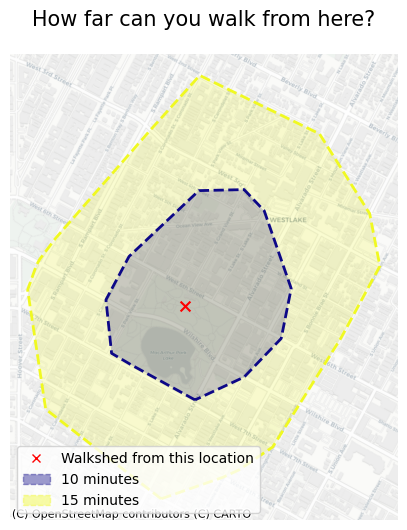

In [2]:
# configure the place, network type, trip times, and travel speed
latlon = [34.059644777881374, -118.27731316248183]
network_type = 'walk'
trip_times = [10,15] 
meters_per_minute = 75 # travel distance per minute
cmap = 'plasma'
title = 'How far can you walk from here?'

# download the street network
G = ox.graph_from_point(latlon, network_type=network_type, dist = 2000)

# project our network data to Web Mercator (measurements are in meters)
G = ox.project_graph(G, to_crs='epsg:3857')

# convert nodes and edges to geodataframes
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# get the bounding box coordinates
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds

# calculate the centroid
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny

# use osmnx's distance.nearest_nodes command to get the id for the nearest node
center_node = ox.distance.nearest_nodes(G,Y=centroid_y,X=centroid_x)

# create a new column, calculate the time it takes to travel that edge
gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

# assign a color hex code for each trip time isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap=cmap, 
                                start=0, 
                                return_hex=True)

# create a list of "zipped" time/colors
time_color = list(zip(trip_times, iso_colors))

# reverse the order so that outside nodes get associated first
time_color.reverse()

# loop through each trip time and associated color
for time, color in list(time_color):

    # for each trip time, create an egograph of nodes that fall within that distance
    subgraph = nx.ego_graph(G, center_node, radius=time)

    # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = time
        gdf_nodes.loc[node,'color'] = color

# the NaN values then need to be populated with a valid color
gdf_nodes['color'].fillna('#cccccc', inplace=True)

# dissolve the nodes by time
# adding the "time" argument creates a separate geometry (multipoint in this case) for each unique time category
isochrones = gdf_nodes.dissolve(by = "time")

# for each row, create a convex hull
isochrones = isochrones.convex_hull.reset_index(name='geometry')

# reverse the order so that outer polygon gets drawn first
isochrones.sort_values(by='time', ascending=False,inplace=True)

# reverse the colors too!
iso_colors.reverse()

########################

#    Make the map!

########################
# set up the subplots
fig, ax = plt.subplots(figsize=(5,8))

# add the isochrone boundary
isochrones.boundary.plot(
    ax=ax,
    alpha=1,
    linestyle='--',
    color=iso_colors,
    lw=2
    ) 

# add the isochrones
isochrones.plot(
    ax=ax, 
    alpha=0.2, 
    categorical=True, # even though it is numeric, treat it as categorical
    color=iso_colors,
    )

# add the center node in red
gdf_nodes.loc[[center_node]].plot(
    ax=ax,
    color='r',
    marker='x',
    markersize=50
    )

# build custom legend
legend_elements = [
    # add the center node to the legend
    Line2D([0], [0], marker='x', color='red', linestyle='',label='Walkshed from this location', markersize=6),
    ]

# sort back to small time to large time
# time_color.sort(reverse=False)
time_color.reverse()

# loop through the list of time/colors and add each to the legend
for time,color in list(time_color):
    legend_item = Patch(facecolor=color, edgecolor=color, linestyle='--',linewidth=1,label=str(time)+' minutes',alpha=0.4)
    legend_elements.append(legend_item)

# add the legend
ax.legend(handles=legend_elements,loc='lower left') # location options: upper/center/lower and left/center/right

# add a title
ax.set_title(title,fontsize=15,pad=10)

# hide the axis
ax.axis('off')

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Now here's the challenge. Modify the cell above and make it into a **function**. Here are the steps to do so:

1. select the entire code within the cell (click within and ctrl-A), and indent each line to the right (tab)
1. at the top of the cell, make it into a function by adding a line of code ```def isomap():```
1. run the cell to ensure that the function has been created (there will be no output)
1. create a new code cell below, and "call" the function ```isomap()```

In [5]:
# call your new function 
def isomap(latlon=[34.059644777881374, -118.27731316248183]):
    # configure the place, network type, trip times, and travel speed
    #latlon = [34.059644777881374, -118.27731316248183]
    latlon = latlon
    network_type = 'walk'
    trip_times = [10,15] 
    meters_per_minute = 75 # travel distance per minute
    cmap = 'plasma'
    title = 'How far can you walk from here?'

# download the street network
    G = ox.graph_from_point(latlon, network_type=network_type, dist = 2000)

# project our network data to Web Mercator (measurements are in meters)
    G = ox.project_graph(G, to_crs='epsg:3857')

# convert nodes and edges to geodataframes
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# get the bounding box coordinates
    minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds

# calculate the centroid
    centroid_x = (maxx-minx)/2 + minx
    centroid_y = (maxy-miny)/2 + miny

# use osmnx's distance.nearest_nodes command to get the id for the nearest node
    center_node = ox.distance.nearest_nodes(G,Y=centroid_y,X=centroid_x)

# create a new column, calculate the time it takes to travel that edge
    gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

# assign a color hex code for each trip time isochrone
    iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap=cmap, 
                                start=0, 
                                return_hex=True)

# create a list of "zipped" time/colors
    time_color = list(zip(trip_times, iso_colors))

# reverse the order so that outside nodes get associated first
    time_color.reverse()

# loop through each trip time and associated color
    for time, color in list(time_color):

    # for each trip time, create an egograph of nodes that fall within that distance
        subgraph = nx.ego_graph(G, center_node, radius=time)

    # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
        for node in subgraph.nodes():
            gdf_nodes.loc[node,'time'] = time
            gdf_nodes.loc[node,'color'] = color

# the NaN values then need to be populated with a valid color
    gdf_nodes['color'].fillna('#cccccc', inplace=True)

# dissolve the nodes by time
# adding the "time" argument creates a separate geometry (multipoint in this case) for each unique time category
    isochrones = gdf_nodes.dissolve(by = "time")

# for each row, create a convex hull
    isochrones = isochrones.convex_hull.reset_index(name='geometry')

# reverse the order so that outer polygon gets drawn first
    isochrones.sort_values(by='time', ascending=False,inplace=True)

# reverse the colors too!
    iso_colors.reverse()

########################

#    Make the map!

########################
# set up the subplots
    fig, ax = plt.subplots(figsize=(5,8))

# add the isochrone boundary
    isochrones.boundary.plot(
        ax=ax,
        alpha=1,
        linestyle='--',
        color=iso_colors,
        lw=2
        ) 

# add the isochrones
    isochrones.plot(
        ax=ax, 
        alpha=0.2, 
        categorical=True, # even though it is numeric, treat it as categorical
        color=iso_colors,
        )

# add the center node in red
    gdf_nodes.loc[[center_node]].plot(
        ax=ax,
        color='r',
        marker='x',
        markersize=50
        )

# build custom legend
    legend_elements = [
    # add the center node to the legend
        Line2D([0], [0], marker='x', color='red', linestyle='',label='Walkshed from this location', markersize=6),
        ]

# sort back to small time to large time
# time_color.sort(reverse=False)
    time_color.reverse()

# loop through the list of time/colors and add each to the legend
    for time,color in list(time_color):
        legend_item = Patch(facecolor=color, edgecolor=color, linestyle='--',linewidth=1,label=str(time)+' minutes',alpha=0.4)
        legend_elements.append(legend_item)

# add the legend
    ax.legend(handles=legend_elements,loc='lower left') # location options: upper/center/lower and left/center/right

# add a title
    ax.set_title(title,fontsize=15,pad=10)

# hide the axis
    ax.axis('off')

# add the basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

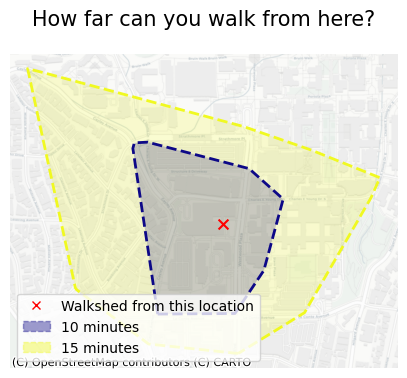

In [9]:
isomap([34.06668349224906, -118.44605743806373])

All good! But calling the function will always create *the same map*. We want the function to generate different maps based on *arguments* that we feed it.

Start by creating an argument for ```latlon```. In other words, feeding the function a latlon pair of coordinates will generate an isochrone map *for that location*.

To do so:

1. add ```latlon``` as an argument in the function declaration (line 1), and give it a default set of coordinates:
```
    def isomap(latlon=[34.059644777881374, -118.27731316248183]):
```
2. now your function is prepared to "receive" an argument for ```latlon```, and it even has a set of default coordinates
3. next, your function needs to know to accept an argument for a ```latlon``` pair fed to it. In the first line of code following the function declaration, replace the coordinates with the argument variable:

```    
    latlon = latlon
```

4. That's it! Now you should be able to run the function, feeding it an argument for ```latlon```, and it should generate a map for that location. Test it out in the cell below. If you need a pair of coordinates, go to google maps and right click anywhere in the world to copy a pair of coordinates.

In [ ]:
# call your function with an argument for latlon


You're on a roll now. The sky is the limit! Create additional arguments to make your function truly dynamic. Here are a few ideas:

- ```trip_times```
- ```cmap```
- ```title```
- ```basemap``` (advanced)
- an argument that specifies whether to output a static map or interactive map (super advanced)